## 프로젝트 기반 빅데이터 서비스 솔루션 개발 전문 과정

#### 교과목명: 딥러닝 응용
- 평가일: 22.05.20
- 성명:권혁종
- 점수: 90

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Q1. mnist datasets를 불러와서 PyTorch 프레임워크으로 다음을 수행하세요.
- 생성자 및 판별자 클래스 정의 및 학습데이터 불러오기
- 모델 학습 및 샘플링
 - 학습을 위한 생성자와 판매자 모델 초기화
 - 적절한 하이퍼 파라미터 설정(lr = 0.0002, betas=(0.5, 0.999))
 - 모델을 학습하면서 주기적으로 샘플링하여 결과 확인(n_epochs = 200, sample_interval = 2000)
- 생성된 이미지 예시 출력 

In [61]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [67]:
latent_dim = 100

# 생성자 클래스 정의
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    # 하나의 블록(block) 정의
    def block(input_dim, output_dim, normalize=True):
      layers = [nn.Linear(input_dim, output_dim)]
      if normalize:
        layers.append(nn.BatchNorm1d(output_dim,0.8)) # 배치 정규화 수행(차원 동일)
      layers.append(nn.LeakyReLU(0.2,inplace=True))
      return layers

    # 생성자 모델은 연속적인 여러 개의 블록을 가짐
    self.model = nn.Sequential(
        *block(latent_dim, 128,normalize=False),
        *block(128,256),
        *block(256,512),
        *block(512,1024),
        nn.Linear(1024,1*28*28),
        nn.Tanh()
    )

  def forward(self,z):
    img = self.model(z) # 노이즈 벡터 z
    # 이미지 형태로 만들어줌
    img = img.view(img.size(0), 1, 28, 28) # 배치 사이즈, 채널, 넓이, 높이
    return img

In [71]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator,self).__init__()

    self.model = nn.Sequential(
        nn.Linear(1*28*28,512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(256,1),
        nn.Sigmoid(), # 확률값을 내보냄
    )

    # 이미지에 대한 판별 결과를 반환
  def forward(self, img):
    flattened = img.view(img.size(0),-1)
    output = self.model(flattened)
    return output

In [72]:
# 학습 데이터셋 불러오기
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

train_dataset = datasets.MNIST(root='./dataset', train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,shuffle=True, num_workers=4)

In [73]:
# 생성자, 판별자 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 손실 함수
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

# 학습률 설정
lr = 0.0002

# 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(),lr=lr, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))

In [74]:
import time

n_epochs = 200
sample_interval = 2000 # 몇 번의 배치마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
  for i, (imgs,_) in enumerate(dataloader):
    # 진짜 이미지와 가짜 이미지에 대한 정답 레이블 생성
    real = torch.cuda.FloatTensor(imgs.size(0),1).fill_(1.0)
    fake = torch.cuda.FloatTensor(imgs.size(0),1).fill_(0.0)

    real_imgs = imgs.cuda()

    ## 생성자 학습
    optimizer_G.zero_grad()

    # 랜덤 노이즈 샘플링
    z = torch.normal(mean=0,std=1,size=(imgs.shape[0], latent_dim)).cuda()   

    # 이미지 생성
    generated_imgs = generator(z)

    # 생성자의 손실 값 계산
    g_loss = adversarial_loss(discriminator(generated_imgs), real)

    # 생성자 업데이트
    g_loss.backward()
    optimizer_G.step()

    ## 판별자 학습
    optimizer_D.zero_grad()

    # 판별자 손실 값 계산
    real_loss = adversarial_loss(discriminator(real_imgs), real)
    fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2

    # 판별자 업데이트
    d_loss.backward()
    optimizer_D.step()

    done = epoch*len(dataloader) + i
    if done % sample_interval == 0:
      # 생성된 이미지 중에서 25개만 선택하여 5x5 격자 이미지에 출력
      save_image(generated_imgs.data[:25], f'{done}.png', nrow=5, normalize=True)
  

   # 하나의 epoch이 끝날 때마다 로그(log) 출력
  print(f'[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]')

[Epoch 0/200] [D loss: 0.510256] [G loss: 0.876439] [Elapsed time: 6.16s]
[Epoch 1/200] [D loss: 0.343780] [G loss: 1.177958] [Elapsed time: 12.35s]
[Epoch 2/200] [D loss: 0.217945] [G loss: 1.875811] [Elapsed time: 18.44s]
[Epoch 3/200] [D loss: 0.320237] [G loss: 1.262033] [Elapsed time: 24.52s]
[Epoch 4/200] [D loss: 0.396093] [G loss: 1.763305] [Elapsed time: 30.51s]
[Epoch 5/200] [D loss: 0.567228] [G loss: 0.598561] [Elapsed time: 36.64s]
[Epoch 6/200] [D loss: 0.346476] [G loss: 2.538068] [Elapsed time: 42.89s]
[Epoch 7/200] [D loss: 0.269589] [G loss: 1.274691] [Elapsed time: 48.90s]
[Epoch 8/200] [D loss: 0.269384] [G loss: 2.383356] [Elapsed time: 54.90s]
[Epoch 9/200] [D loss: 0.370702] [G loss: 3.938446] [Elapsed time: 61.05s]
[Epoch 10/200] [D loss: 0.198635] [G loss: 1.606745] [Elapsed time: 67.91s]
[Epoch 11/200] [D loss: 0.159849] [G loss: 2.534884] [Elapsed time: 76.16s]
[Epoch 12/200] [D loss: 0.197925] [G loss: 2.398204] [Elapsed time: 83.78s]
[Epoch 13/200] [D loss:

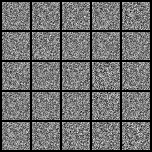

In [80]:
from IPython.display import Image
Image(f'0.png')

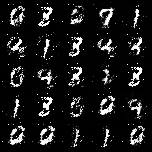

In [84]:
Image(f'20000.png')

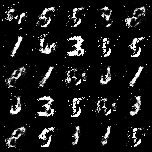

In [85]:
Image(f'40000.png')

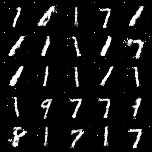

In [83]:
Image(f'60000.png')

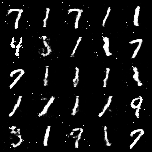

In [81]:
Image(f'92000.png')

Q2. 아래사항을 참조하여 로드된 ECG 데이터를 활용하여 이상치 감지 모델을 만든 후 성능 평가를 수행하세요.

[ECG5000 데이터세트]에서 이상을 감지하도록 autoencoder를 훈련합니다. 이 데이터세트에는 각각 140개의 데이터 포인트가 있는 5,000개의 [심전도]가 포함되어 있습니다. 단순화 된 버전의 데이터세트를 사용하고, 각 예제는 `0`(비정상 리듬에 해당) 또는 `1`(정상 리듬에 해당)으로 레이블이 지정됩니다. 

autoencoder를 사용하여 이상을 어떻게 감지하겠습니까? autoencoder는 재구성 오류를 최소화하도록 훈련되었습니다. autoencoder는 정상 리듬으로만 훈련한 다음 이 autoencoder를 사용하여 모든 데이터를 재구성합니다. 여기서 가설은 비정상 리듬의 경우에 재구성 오류가 더 클 것이라는 것입니다. 그런 다음 재구성 오류가 고정 임계값을 초과하는 경우, 리듬을 이상으로 분류합니다.

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# Download the dataset
import pandas as pd
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [23]:
# 데이터셋 분리
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [24]:
# 데이터셋 0,1로 정규화
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [25]:
# 레이블을 0, 1 로 나누어서 분리
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [26]:
normal_train_data.shape

TensorShape([2359, 140])

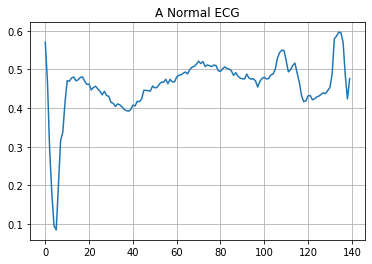

In [27]:
# 정상인 ECG 그래프 출력
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

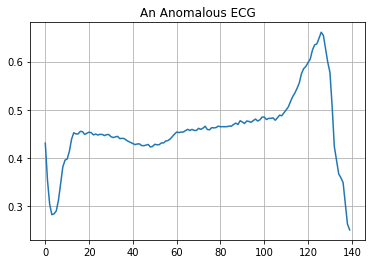

In [28]:
# 비정상인 ECG 그래프 출력
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [29]:
# 모델 만들기
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [30]:
autoencoder.compile(optimizer = 'adam', loss = 'mae')

In [31]:
history = autoencoder.fit(normal_train_data, normal_train_data,
                          epochs = 20,
                          batch_size = 512,
                          validation_data= (test_data, test_data),
                          shuffle = True)

Epoch 1/20
5/5 [==============================] - 4s 56ms/step - loss: 0.0590 - val_loss: 0.0536
Epoch 2/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0568 - val_loss: 0.0527
Epoch 3/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0553 - val_loss: 0.0522
Epoch 4/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0527 - val_loss: 0.0507
Epoch 5/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0493 - val_loss: 0.0489
Epoch 6/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0453 - val_loss: 0.0464
Epoch 7/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0410 - val_loss: 0.0444
Epoch 8/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0368 - val_loss: 0.0423
Epoch 9/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0336 - val_loss: 0.0405
Epoch 10/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0310 - val_loss: 0.0392
Epoch 11/20
5/5 [================

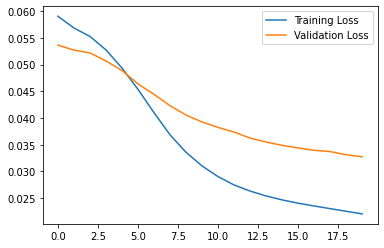

In [32]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

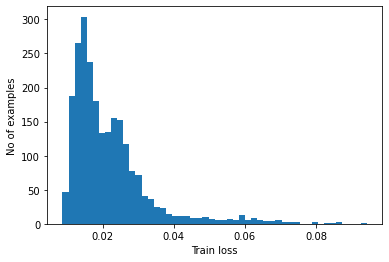

In [33]:
# 재구성 손실이 고정 임계값보다 큰지 여부를 계산하여 이상을 감지
# train에서 정상 ECG에 대한 재구성 오류
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [34]:
# 평균보다 표준 편차가 높은 임계값을 선택
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.033031773


In [35]:
# 재구성 오류가 임계값보다 큰 경우 ECG를 이상
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [36]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.943
Precision = 0.9941060903732809
Recall = 0.9035714285714286


Q3. YOLOv5를 활용하고 포트홀 데이터로 파인튜닝하여 "포트홀 탐지모델"을 개발하고 테스트 데이터 샘플에 대하여 포트홀 탐지가 되는지 확인하세요.

YOLOv5 : https://github.com/ultralytics/yolov5.git<br>
포트홀 데이터 : https://public.roboflow.com/object-detection/pothole

In [1]:
%cd /content
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
from IPython.display import Image, clear_output

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 13599, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 13599 (delta 87), reused 102 (delta 71), pack-reused 13476
Receiving objects: 100% (13599/13599), 12.15 MiB | 14.19 MiB/s, done.
Resolving deltas: 100% (9487/9487), done.
/content/yolov5
     |████████████████████████████████| 596 kB 4.3 MB/s 


In [2]:
%mkdir /content/yolov5/pothole
%cd /content/yolov5/pothole

/content/yolov5/pothole


In [3]:
!curl -L "https://public.roboflow.com/ds/B83TMltOnm?key=4YYZyFFwNm" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0    938      0 --:--:-- --:--:-- --:--:--   937
100 46.0M  100 46.0M    0     0  10.1M      0  0:00:04  0:00:04 --:--:-- 19.3M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg  
 extracting: test/images/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jpg  
 extracting: test/images/img-146_jpg.rf.61be25b3053a51f622a244980545df2b.jpg  
 extracting: test/images/img-161_jpg.rf.211541e7178a4a93ec0680f26b905427.jpg  
 extracting: test/images/img-168_jpg.rf.af3590e07b06b43e91fa53990ff94af3.jpg  
 extracting: test/images/img-179_jpg.rf.8632eb0d9b75fefe144829e67b75015a.jpg  
 extracting: test/images/img

In [4]:
from glob import glob
train_img_list = glob('/content/yolov5/pothole/train/images/*.jpg')
test_img_list = glob('/content/yolov5/pothole/test/images/*.jpg')
valid_img_list = glob('/content/yolov5/pothole/valid/images/*.jpg')
print(len(train_img_list), len(test_img_list), len(valid_img_list))

465 67 133


In [5]:
import yaml
with open('/content/yolov5/pothole/train.txt', 'w') as f:
  f.write('\n'.join(train_img_list)+'\n')
with open('/content/yolov5/pothole/test.txt', 'w') as f:
  f.write('\n'.join(test_img_list)+'\n')
with open('/content/yolov5/pothole/valid.txt', 'w') as f:
  f.write('\n'.join(valid_img_list)+'\n')

In [6]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line,cell):
  with open(line,'w') as f:
    f.write(cell.format(**globals()))

In [7]:
%cat /content/yolov5/pothole/data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['pothole']

In [8]:
%%writetemplate /content/yolov5/pothole/data.yaml
train: ./pothole/train/images
test: ./pothole/test/images
val: ./pothole/valid/images

nc: 1
names: ['pothole']

In [9]:
%cat /content/yolov5/pothole/data.yaml

train: ./pothole/train/images
test: ./pothole/test/images
val: ./pothole/valid/images

nc: 1
names: ['pothole']

In [10]:
# 모델 구성
with open('/content/yolov5/pothole/data.yaml','r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])

num_classes

'1'

In [11]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [12]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: {num_classes} # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [13]:
%%time
%cd /content/yolov5/
!python train.py --img 640 --batch 32 --epochs 100 --data ./pothole/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name pothole_results --cache

/content/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=./pothole/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=pothole_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-204-gf43cd53 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, ancho

In [14]:
!ls /content/yolov5/runs/train/pothole_results/

confusion_matrix.png				   results.png
events.out.tfevents.1653006079.62055a596170.204.0  train_batch0.jpg
F1_curve.png					   train_batch1.jpg
hyp.yaml					   train_batch2.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
opt.yaml					   val_batch1_labels.jpg
P_curve.png					   val_batch1_pred.jpg
PR_curve.png					   val_batch2_labels.jpg
R_curve.png					   val_batch2_pred.jpg
results.csv					   weights


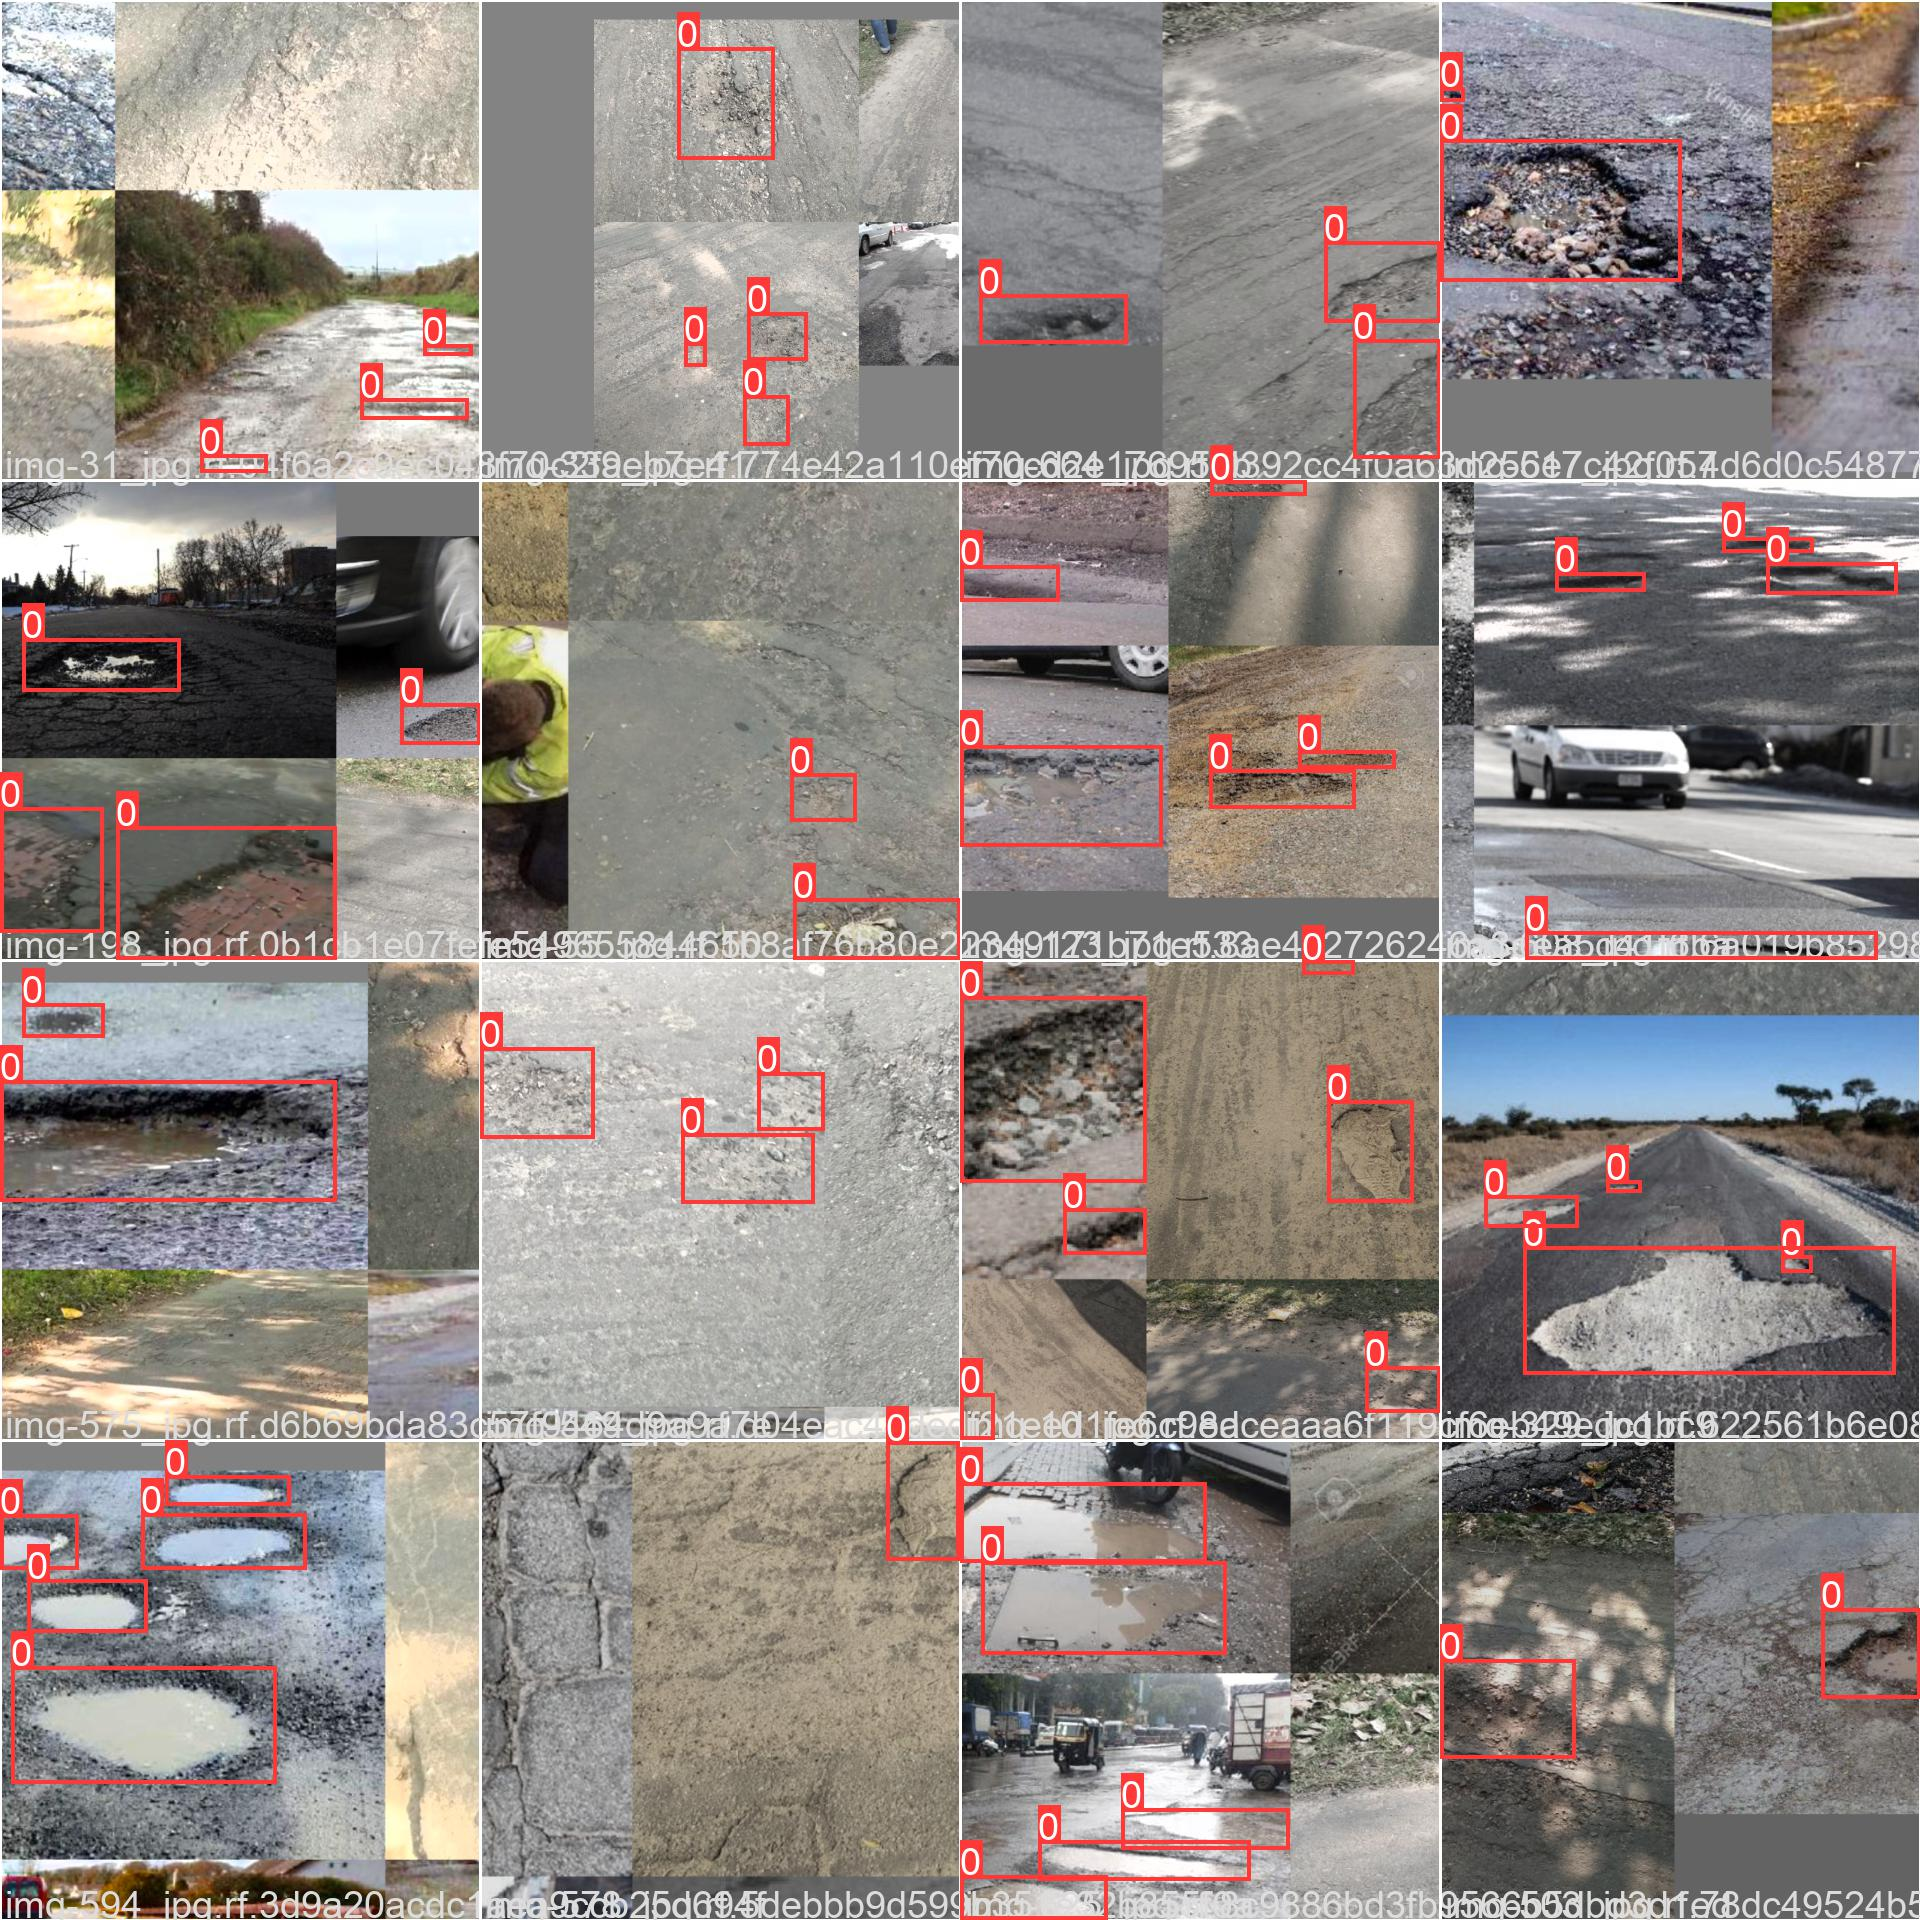

In [15]:
Image(filename='/content/yolov5/runs/train/pothole_results/train_batch0.jpg', width=1000)

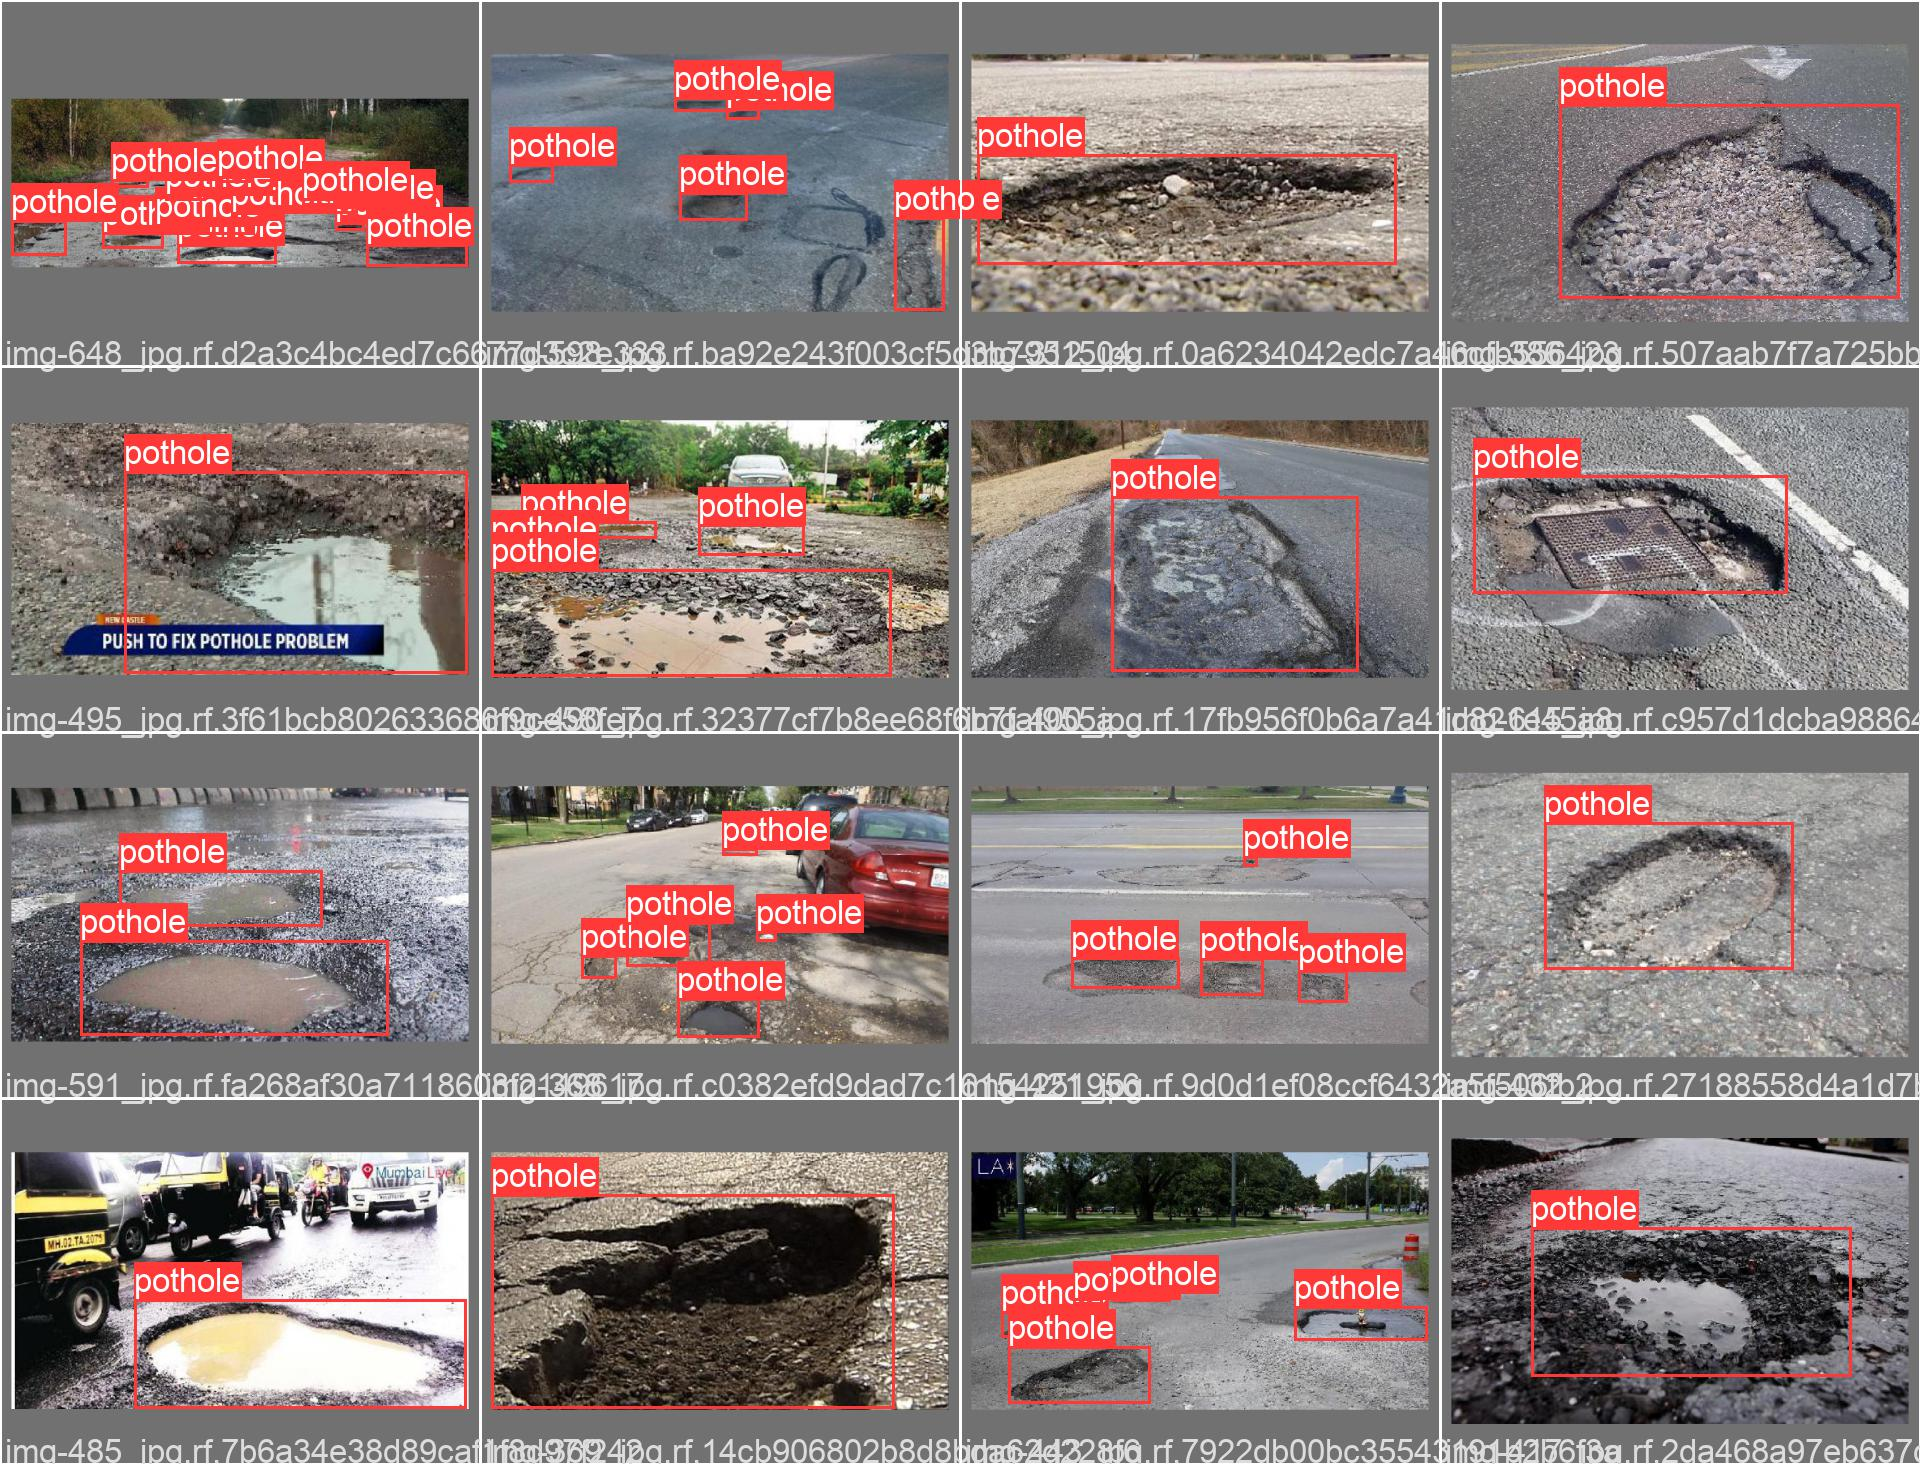

In [16]:
Image(filename='/content/yolov5/runs/train/pothole_results/val_batch0_labels.jpg', width=1000)

In [17]:
!python val.py --weights runs/train/pothole_results/weights/best.pt --data./pothole/data.yaml --img640 --task test

usage: val.py [-h] [--data DATA] [--weights WEIGHTS [WEIGHTS ...]]
              [--batch-size BATCH_SIZE] [--imgsz IMGSZ]
              [--conf-thres CONF_THRES] [--iou-thres IOU_THRES] [--task TASK]
              [--device DEVICE] [--workers WORKERS] [--single-cls] [--augment]
              [--verbose] [--save-txt] [--save-hybrid] [--save-conf]
              [--save-json] [--project PROJECT] [--name NAME] [--exist-ok]
              [--half] [--dnn]
val.py: error: unrecognized arguments: --data./pothole/data.yaml --img640


In [18]:
!python detect.py --weights runs/train/pothole_results/weights/best.pt --img 640 --conf 0.4 --source ./pothole/test/images

detect: weights=['runs/train/pothole_results/weights/best.pt'], source=./pothole/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-204-gf43cd53 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
custom_YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/67 /content/yolov5/pothole/test/images/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg: 640x640 2 potholes, Done. (0.010s)
image 2/67 /content/yolov5/pothole/test/images/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jpg: 640x640 1 pothole, Done. (0.007s)
image 3/67 /content/yolov5/pothole/test/images/img-146_jp

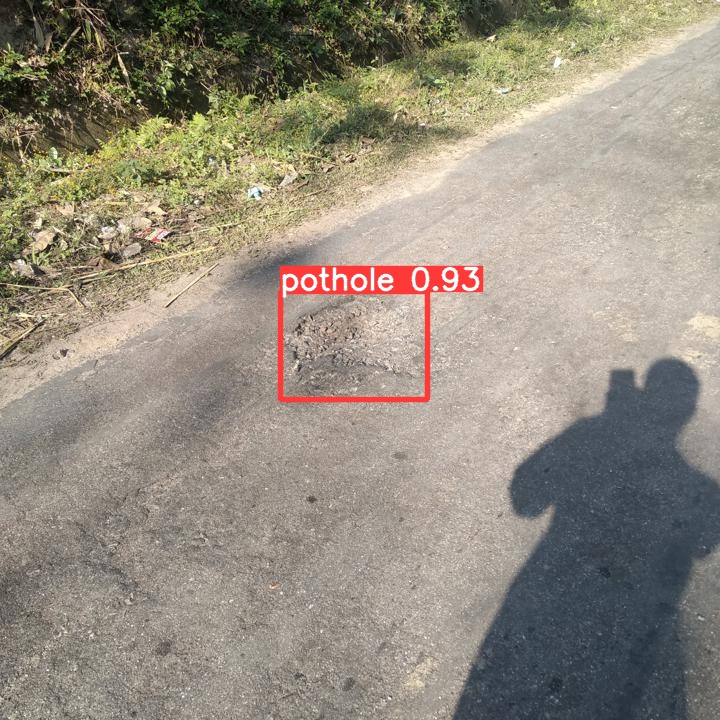

In [20]:
import glob
import random
from IPython.display import Image, display

image_name = random.choice(glob.glob('/content/yolov5/runs/detect/exp/*.jpg'))
display(Image(filename=image_name))

In [ ]:
image_name = random.choice(glob.glob('/content/yolov5/runs/detect/exp/*.jpg'))
display(Image(filename=image_name))

Q4~5. 주어진 네이버 댓글 데이터 ratings_train.txt, ratings_test.txt 를 활용하여 아래 요구사항에 따라 감성분석 모델 생성 및 평가를 수행하세요.
- pre-trained model로 kobert 사용
- pre-trained model로 bert multilingual 사용

In [37]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 4.2 MB/s 
     |████████████████████████████████| 6.6 MB 44.3 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 


In [38]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.1 MB/s 


In [39]:
!pip install sacremoses

     |████████████████████████████████| 880 kB 4.2 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=902b5c440cd12358b7acc0004518fb440ebced6649c3bca7b9e1877d06f0a4ee
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [40]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
from tqdm import tqdm
import os
import re
import sentencepiece as spm

In [41]:
# 네이버 댓글 데이터 가져오기
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 13.67 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [42]:
# train, test 데이터 가져오기
train = pd.read_table('nsmc/' + 'ratings_train.txt')
test = pd.read_table('nsmc/'+'ratings_test.txt')
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [43]:
# tokenization_kobert.py 업로드
from google.colab import files 
files.upload()

Saving tokenization_kobert.py to tokenization_kobert.py


{'tokenization_kobert.py': b'# coding=utf-8\n# Copyright 2018 Google AI, Google Brain and Carnegie Mellon University Authors and the HuggingFace Inc. team and Jangwon Park\n#\n# Licensed under the Apache License, Version 2.0 (the "License");\n# you may not use this file except in compliance with the License.\n# You may obtain a copy of the License at\n#\n#     http://www.apache.org/licenses/LICENSE-2.0\n#\n# Unless required by applicable law or agreed to in writing, software\n# distributed under the License is distributed on an "AS IS" BASIS,\n# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n# See the License for the specific language governing permissions and\n# limitations under the License.\n""" Tokenization classes for KoBert model."""\n\n\nimport logging\nimport os\nimport unicodedata\nfrom shutil import copyfile\n\nfrom transformers import PreTrainedTokenizer\n\n\nlogger = logging.getLogger(__name__)\n\nVOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3

In [45]:
from tokenization_kobert import KoBertTokenizer
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

https://huggingface.co/monologg/kobert/resolve/main/tokenizer_78b3253a26.model not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp23wa64t2


Downloading:   0%|          | 0.00/363k [00:00<?, ?B/s]

storing https://huggingface.co/monologg/kobert/resolve/main/tokenizer_78b3253a26.model in cache at /root/.cache/huggingface/transformers/7e55d7972628e6fc1babc614b5dd8bb43ab4f9d8541adc9fb1851112a7a7c5cc.4d2f4af7c2ca9df5b147978a95d38840e84801a378eee25756b008638e0bdc7f
creating metadata file for /root/.cache/huggingface/transformers/7e55d7972628e6fc1babc614b5dd8bb43ab4f9d8541adc9fb1851112a7a7c5cc.4d2f4af7c2ca9df5b147978a95d38840e84801a378eee25756b008638e0bdc7f
https://huggingface.co/monologg/kobert/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpuj0botfl


Downloading:   0%|          | 0.00/76.0k [00:00<?, ?B/s]

storing https://huggingface.co/monologg/kobert/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/efee434f5f4c5c89b5a7d8d5f30bbb0496f1540349fcfa21729cec5b96cfd2d1.719459e20bc981bc2093e859b02c3a3e51bab724d6b58927b23b512a3981229f
creating metadata file for /root/.cache/huggingface/transformers/efee434f5f4c5c89b5a7d8d5f30bbb0496f1540349fcfa21729cec5b96cfd2d1.719459e20bc981bc2093e859b02c3a3e51bab724d6b58927b23b512a3981229f
https://huggingface.co/monologg/kobert/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpjl_6p4u5


Downloading:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

storing https://huggingface.co/monologg/kobert/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/d1c07e179f5e00959a3c8e4a150eaa4907dfe26544e4a71f2b0163982a476523.767d1b760a83978bae6c324157fad57ee513af333a7cea6986e852579f6f0dd1
creating metadata file for /root/.cache/huggingface/transformers/d1c07e179f5e00959a3c8e4a150eaa4907dfe26544e4a71f2b0163982a476523.767d1b760a83978bae6c324157fad57ee513af333a7cea6986e852579f6f0dd1
loading file https://huggingface.co/monologg/kobert/resolve/main/tokenizer_78b3253a26.model from cache at /root/.cache/huggingface/transformers/7e55d7972628e6fc1babc614b5dd8bb43ab4f9d8541adc9fb1851112a7a7c5cc.4d2f4af7c2ca9df5b147978a95d38840e84801a378eee25756b008638e0bdc7f
loading file https://huggingface.co/monologg/kobert/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/efee434f5f4c5c89b5a7d8d5f30bbb0496f1540349fcfa21729cec5b96cfd2d1.719459e20bc981bc2093e859b02c3a3e51bab724d6b58927b23b512a3981229f
loading file

Downloading:   0%|          | 0.00/426 [00:00<?, ?B/s]

storing https://huggingface.co/monologg/kobert/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/31dc8da633439f22ed80bede01f337996bc709eb8429f86f2b24e2103558b039.89a06cdfd16840fd89cc5c2493ef63cd0b6068e85f70ac988a3673e2722cab2e
creating metadata file for /root/.cache/huggingface/transformers/31dc8da633439f22ed80bede01f337996bc709eb8429f86f2b24e2103558b039.89a06cdfd16840fd89cc5c2493ef63cd0b6068e85f70ac988a3673e2722cab2e
loading configuration file https://huggingface.co/monologg/kobert/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/31dc8da633439f22ed80bede01f337996bc709eb8429f86f2b24e2103558b039.89a06cdfd16840fd89cc5c2493ef63cd0b6068e85f70ac988a3673e2722cab2e
Model config BertConfig {
  "_name_or_path": "monologg/kobert",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,


In [86]:
def convert_data(data_df):
  global tokenizer
  SEQ_LEN = 64

  tokens, masks, segments, targets = [],[],[],[]

  for i in tqdm(range(len(data_df))):
    token = tokenizer.encode(data_df[DATA_COLUMN][i], truncation = True, padding = 'max_length' , max_length = SEQ_LEN)
    num_zeros = token.count(0)
    mask = [1] * (SEQ_LEN - num_zeros) + [0] * num_zeros
    segment = [0] * SEQ_LEN
    tokens.append(token)
    masks.append(mask)
    segments.append(segment)

    targets.append(data_df[LABEL_COLUMN][i])

  tokens = np.array(tokens)
  masks = np.array(masks)
  segments = np.array(segments)
  targets = np.array(targets)

  return [tokens, masks, segments], targets


In [87]:
def load_data(pandas_dataframe):
  data_df=  pandas_dataframe
  data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
  data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
  data_x, data_y = convert_data(data_df)
  return data_x, data_y

In [88]:
SEQ_LEN = 64
BATCH_SIZE = 32
DATA_COLUMN = 'document'
LABEL_COLUMN = 'label'

train_x, train_y = load_data(train)

100%|██████████| 150000/150000 [00:30<00:00, 4885.05it/s]


In [89]:
test_x, test_y = load_data(test)

100%|██████████| 50000/50000 [00:09<00:00, 5089.32it/s]


In [90]:
# kobert를 활용한 모델 생성

model = TFBertModel.from_pretrained('monologg/kobert',from_pt = True)
token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name = 'input_masks')
segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name = 'input_segment')

bert_output = model([token_inputs, mask_inputs, segment_inputs])

loading configuration file https://huggingface.co/monologg/kobert/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/31dc8da633439f22ed80bede01f337996bc709eb8429f86f2b24e2103558b039.89a06cdfd16840fd89cc5c2493ef63cd0b6068e85f70ac988a3673e2722cab2e
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 8002
}

loading weights file https://huggingface.co/monologg/kobert/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9525d

In [91]:
bert_output = bert_output[1]
bert_output.shape

TensorShape([None, 768])

In [92]:
# optimizer

!pip install tensorflow_addons

In [98]:
import tensorflow_addons as tfa
opt = tfa.optimizers.RectifiedAdam(lr=5.0e-5, total_steps=1172*2,warmup_proportion=0.1, min_lr=1e-5,epsilon=1e-08, clipnorm=1.0)

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [99]:
sentiment_drop = tf.keras.layers.Dropout(0.5)(bert_output)
sentiment_first = tf.keras.layers.Dense(1,activation='sigmoid',kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(sentiment_drop)
sentiment_model = tf.keras.Model([token_inputs,mask_inputs,segment_inputs],sentiment_first)
sentiment_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [100]:
sentiment_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 64)]         0           []                               
                                                                                                  
 input_segment (InputLayer)     [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  92186880    ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_masks[0][0]',      

In [101]:
sentiment_model.fit(train_x,train_y,epochs=2,shuffle=True,batch_size=128,validation_data=(test_x,test_y))

Epoch 1/2
1172/1172 [==============================] - 1207s 1s/step - loss: 0.2921 - accuracy: 0.8773 - val_loss: 0.2727 - val_accuracy: 0.8907
Epoch 2/2
1172/1172 [==============================] - 1177s 1s/step - loss: 0.1927 - accuracy: 0.9256 - val_loss: 0.2674 - val_accuracy: 0.8981


In [102]:
sentiment_model.evaluate(test_x,test_y)

1563/1563 [==============================] - 147s 94ms/step - loss: 0.2674 - accuracy: 0.8981


[0.2674046754837036, 0.898140013217926]

 # bert multilingual 사용

In [103]:
# 데이터는 그대로 사용하되 토크나이저와 사전훈련 모델만 변경
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

https://huggingface.co/bert-base-multilingual-cased/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpgcynk42g


Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-multilingual-cased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/eff018e45de5364a8368df1f2df3461d506e2a111e9dd50af1fae061cd460ead.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
creating metadata file for /root/.cache/huggingface/transformers/eff018e45de5364a8368df1f2df3461d506e2a111e9dd50af1fae061cd460ead.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
https://huggingface.co/bert-base-multilingual-cased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpxkbsynfh


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-multilingual-cased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/f55e7a2ad4f8d0fff2733b3f79777e1e99247f2e4583703e92ce74453af8c235.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
creating metadata file for /root/.cache/huggingface/transformers/f55e7a2ad4f8d0fff2733b3f79777e1e99247f2e4583703e92ce74453af8c235.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/eff018e45de5364a8368df1f2df3461d506e2a111e9dd50af1fae061cd460ead.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://hug

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
creating metadata file for /root/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
loading configuration file https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidde

In [104]:
SEQ_LEN = 64
BATCH_SIZE = 32
DATA_COLUMN = 'document'
LABEL_COLUMN = 'label'

train_x, train_y = load_data(train)

100%|██████████| 150000/150000 [00:50<00:00, 2996.44it/s]


In [105]:
test_x, test_y = load_data(test)

100%|██████████| 50000/50000 [00:16<00:00, 3065.49it/s]


In [106]:
model = TFBertModel.from_pretrained('bert-base-multilingual-cased', from_pt=True)
# 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')

# 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

loading configuration file https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-multilingual-cased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/0a3fd51713dcbb4def175c7f85bddc995d5976ce1dde327f99104e4d33069f17.aa7be4c79d76f4066d9b354496ea477c9ee39c5d889156dd1efb680643c2b052
creating metadata file for /root/.cache/huggingface/transformers/0a3fd51713dcbb4def175c7f85bddc995d5976ce1dde327f99104e4d33069f17.aa7be4c79d76f4066d9b354496ea477c9ee39c5d889156dd1efb680643c2b052
loading weights file https://huggingface.co/bert-base-multilingual-cased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/0a3fd51713dcbb4def175c7f85bddc995d5976ce1dde327f99104e4d33069f17.aa7be4c79d76f4066d9b354496ea477c9ee39c5d889156dd1efb680643c2b052
Loading PyTorch weights from /root/.cache/huggingface/transformers/0a3fd51713dcbb4def175c7f85bddc995d5976ce1dde327f99104e4d33069f17.aa7be4c79d76f4066d9b354496ea477c9ee39c5d889156dd1efb680643c2b052
PyTorch checkpoint contains 270,378,749 parameters


In [107]:
bert_outputs = bert_outputs[1]

In [108]:
# import tensorflow_addons as tfa

In [109]:
opt = tfa.optimizers.RectifiedAdam(lr=5.0e-5, total_steps = 2344*2, warmup_proportion=0.1, min_lr=1e-5, epsilon=1e-08, clipnorm=1.0)

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [110]:
sentiment_drop = tf.keras.layers.Dropout(0.5)(bert_outputs)
sentiment_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(sentiment_drop)
sentiment_model_v2 = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_first)
sentiment_model_v2.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])
sentiment_model_v2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 64)]         0           []                               
                                                                                                  
 input_segment (InputLayer)     [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  177853440   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_masks[0][0]',      

In [112]:
sentiment_model_v2.fit(train_x, train_y, epochs=2, shuffle=True, batch_size=64, validation_data=(test_x, test_y))

Epoch 1/2
2344/2344 [==============================] - 1336s 570ms/step - loss: 0.4162 - accuracy: 0.7961 - val_loss: 0.3562 - val_accuracy: 0.8431
Epoch 2/2
2344/2344 [==============================] - 1332s 568ms/step - loss: 0.2937 - accuracy: 0.8729 - val_loss: 0.3124 - val_accuracy: 0.8682


In [113]:
sentiment_model_v2.evaluate(test_x,test_y)

1563/1563 [==============================] - 145s 93ms/step - loss: 0.3124 - accuracy: 0.8682


[0.3124489486217499, 0.868179976940155]